In [1]:
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1 特征工程

In [31]:
# 将特征工程的所有步骤编写成函数，方便后续的数据处理
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ''

def featureEngineering(df):
    # Fare列填补缺失值
    Fare_fillna = preprocessing.Imputer(strategy='median')
    Fare_fillna.fit(titanic[['Fare']])
    df[['Fare']] = Fare_fillna.transform(df[['Fare']])
    
    # Pclass列独热编码
    Pclass_encoder = preprocessing.OneHotEncoder(sparse=False)
    Pclass_encoder.fit(titanic[['Pclass']])
    Pclass = Pclass_encoder.transform(df[['Pclass']])
    Pclass = DataFrame(Pclass)
    Pclass.columns = ['Pclass_1', 'Pclass_2', 'Pclass_3']
    df = pd.concat([df, Pclass], axis=1)
    
    # Sex列二值编码
    Sex_encoder = preprocessing.LabelBinarizer()
    Sex_encoder.fit(titanic[['Sex']])
    Sex_encode = Sex_encoder.transform(df[['Sex']])
    Sex_encode = DataFrame(Sex_encode)
    Sex_encode.columns = ['Sex_encode']
    df = pd.concat([df, Sex_encode], axis=1)
    
    # Age填补缺失值
    Age_fillna = preprocessing.Imputer(strategy='median')
    Age_fillna.fit(df[['Age']])
    df[['Age']] = Age_fillna.transform(df[['Age']])
    
    # Cabin列根据是否缺失编码
    df['Cabin_notnull'] = df['Cabin'].notnull().astype(int)
    
    # Embarked列独热编码
    titanic.ix[titanic.Embarked.isnull(), 'Embarked'] = 'S'
    Embarked_encoder = preprocessing.LabelBinarizer()
    Embarked_encoder.fit(titanic.Embarked)
    df.ix[df.Embarked.isnull(), 'Embarked'] = 'S'
    Embarked = Embarked_encoder.transform(df.Embarked)
    Embarked = DataFrame(Embarked)
    Embarked.columns = ['Embarked_C', 'Embarked_Q', 'Embarked_S']
    df = pd.concat([df, Embarked], axis=1)
    
    # Family_size列
    df['Family_size'] = df['SibSp'] + df['Parch']
    
    # Name_len列
    df['Name_len'] = df['Name'].map(len)
    
    # 根据年龄段进行编码
    bins = [0, 12, 60, 100]
    group_names = ['Age_Child', 'Age_Adult', 'Age_Elder']
    age_cut = pd.get_dummies(pd.cut(df.Age, bins, labels=group_names)).astype(int)
    df = pd.concat([df, age_cut], axis=1)
    
    # Title列
    df_titles = df["Name"].map(get_title)
    df_titles = df_titles.fillna("Mr")
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8,
                     "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

    df['Title'] = df_titles.map(title_mapping)
    df['Title'] = df['Title'].fillna(1)
    
    # 儿童舱室
    Child_Pclass = pd.get_dummies(df['Age_Child'] * df['Pclass']).astype(int)
    Child_Pclass.columns = ['Not_Child', 'Child_1', 'Child_2', 'Child_3']
    Child_Pclass = Child_Pclass.drop('Not_Child', axis=1)
    df = pd.concat([df, Child_Pclass], axis=1)
    
    # 男性成年人舱室
    MaleAdult_Pclass = pd.get_dummies(df['Age_Adult'] * df['Sex_encode'] * df['Pclass']).astype(int)
    MaleAdult_Pclass.columns = ['Not_MaleAdult', 'Male_1', 'Male_2', 'Male_3']
    MaleAdult_Pclass = MaleAdult_Pclass.drop('Not_MaleAdult', axis=1)
    df = pd.concat([df, MaleAdult_Pclass], axis=1)
    
    # 女性成年人舱室
    FemaleAdult_Pclass = pd.get_dummies(df['Age_Adult'] * (1-df['Sex_encode']) * df['Pclass']).astype(int)
    FemaleAdult_Pclass.columns = ['Not_FemaleAdult', 'Female_1', 'Female_2', 'Female_3']
    FemaleAdult_Pclass = FemaleAdult_Pclass.drop('Not_FemaleAdult', axis=1)
    df = pd.concat([df, FemaleAdult_Pclass], axis=1)
    
    return df

In [32]:
titanic = pd.read_csv('./train.csv')
titanic = featureEngineering(titanic)

In [33]:
test = pd.read_csv('./test.csv')
test = featureEngineering(test)

In [34]:
all_predictors = [
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_encode',
    'Cabin_notnull',
    'Embarked_C',
    'Embarked_Q',
    'Embarked_S',
    'Family_size',
    'Name_len',
    'Age_Child',
    'Age_Adult',
    'Age_Elder',
    'Title',
    'Child_1',
    'Child_2',
    'Child_3',
    'Male_1',
    'Male_2',
    'Male_3',
    'Female_1',
    'Female_2',
    'Female_3'
]

# 2 logistics模型

In [9]:
from sklearn.linear_model import LogisticRegression

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score

In [35]:
logit0 = LogisticRegression(random_state=1234, penalty='l2')

In [36]:
logit0_rfecv = RFECV(estimator=logit0, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
logit0_rfecv.fit(titanic[all_predictors], titanic['Survived'])

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

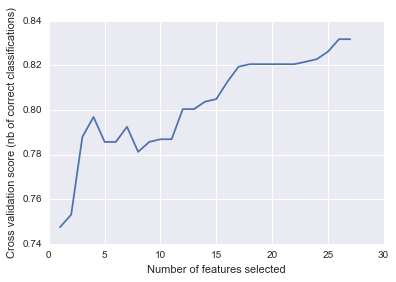

In [37]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(logit0_rfecv.grid_scores_) + 1), logit0_rfecv.grid_scores_);

In [38]:
logit0_rfecv.grid_scores_.max()

0.83167838563692931

### 当所有特征都纳入模型时，交叉验证结果最理想

### 2.1 预测 

In [26]:
cross_val_score(logit0, titanic[all_predictors], titanic['Survived'], cv=5).mean()

0.83165955442733797

In [39]:
logit0.fit(titanic[all_predictors], titanic['Survived'])
logit0_prediction = logit0.predict(test[all_predictors])

In [40]:
logit0_submmison = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': logit0_prediction})
logit0_submmison.to_csv('./logit0_prediction.csv', index=None)

# 3 SVM模型

In [41]:
from sklearn.svm import SVC

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score

In [43]:
svc0 = SVC(random_state=1234)

In [45]:
cross_val_score(svc0, titanic[all_predictors], titanic['Survived'], cv=5).mean()

0.72290197805720791

### SVM模型效果并不理想，需要进一步特征选择和调参